In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyproj import Transformer
import xskillscore as xskill

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

from stats import clean_xs_ys

xr.set_options(keep_attrs = True)

data_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar')
ncs_dir = data_dir.joinpath('ncs')

ds = xr.open_dataset(ncs_dir.joinpath('final_insitu.nc')).isel(x = slice(0, -1, 100), y = slice(0, -1, 100))

In [14]:
sub = ds[['dem', 'int_phase','int_atm','unw_atm', 'model_d_swe','model_swe','cor', 'tree_perc']]
sub = sub.where((sub['model_swe'].min(dim = 'time') > 0) & (~sub['cor'].mean(dim = 'time1').isnull()))

In [ ]:
sub['int_atm'] = sub['int_atm'] - (sub['int_atm'].mean(dim = ['x', 'y']) - model_phase.mean(dim = ['x', 'y']))

NameError: name 'sub' is not defined

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/validation/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


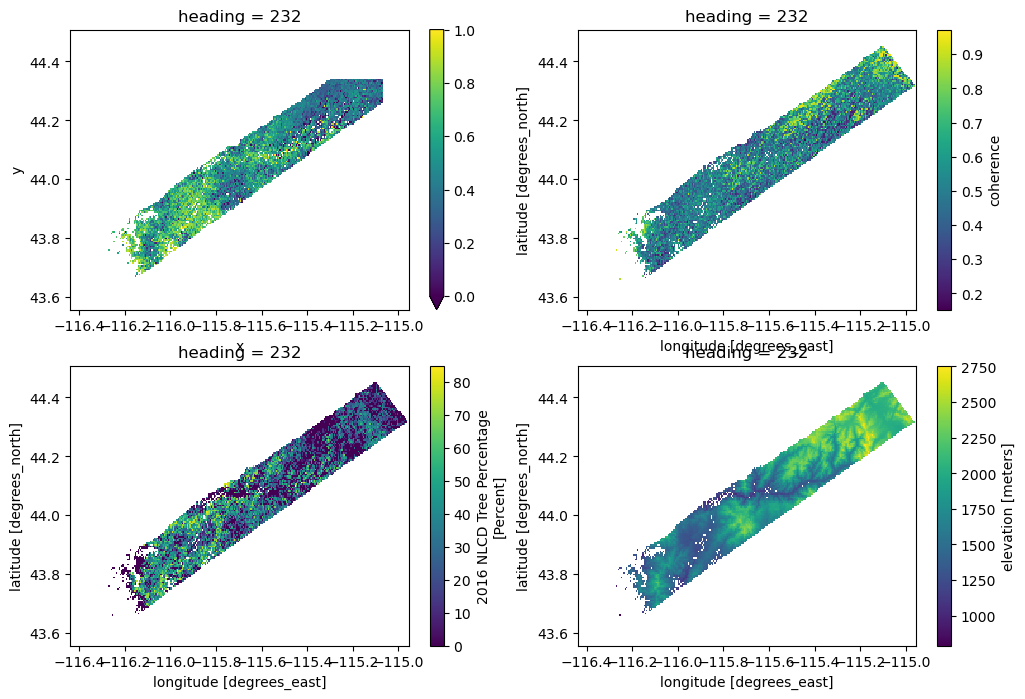

In [16]:
model_phase = phase_from_depth(sub['model_d_swe']*997/250, np.deg2rad(40), density = 250)
fig, axes = plt.subplots(2, 2, figsize = (12, 8))
xskill.pearson_r(sub['int_atm'], model_phase, dim = 'time1', skipna = True).plot(vmax = 1, vmin = 0, ax= axes[0,0])
sub['cor'].mean(dim = 'time1').plot(ax = axes[0,1])
sub['tree_perc'].plot(ax = axes[1, 0])
sub['dem'].plot(ax = axes[1,1])
plt.show()

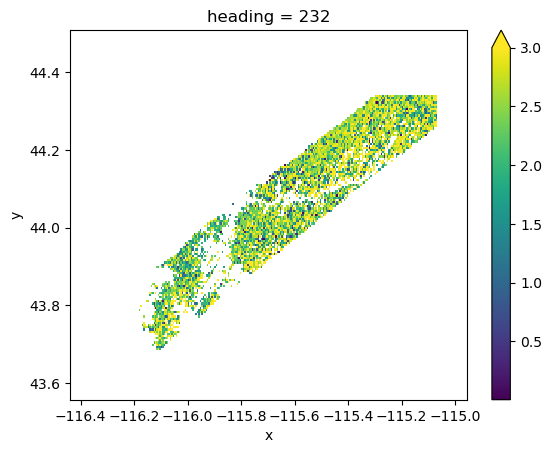

In [49]:
xskill.rmse(sub['int_atm'], sub['model_d_swe'], dim = 'time1', skipna = True).plot(vmax = 3)

In [28]:
sub = sub.where((sub['model_swe'].min(dim = 'time') > 0.1) & (sub['model_d_swe'] > -0.5) & (sub['cor'] > 0.5))

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


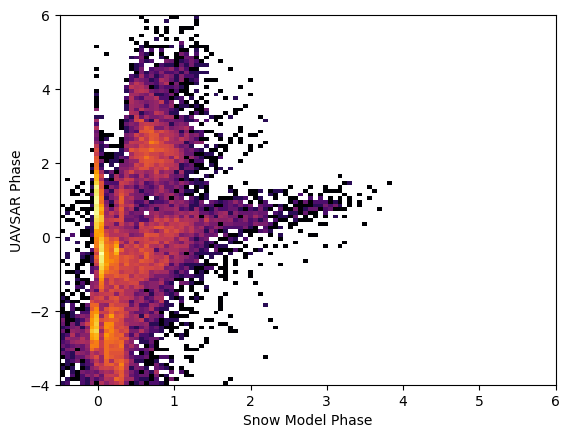

In [29]:
model_phase = phase_from_depth(sub['model_d_swe']*997/250, np.deg2rad(40), density = 250)
xs, ys = clean_xs_ys(model_phase.data.ravel(), sub['unw_atm'].data.ravel())

plt.hist2d(xs, ys, bins = 100, range=[[-0.5,6],[-4,6]], norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)
plt.xlabel('Snow Model Phase')
plt.ylabel('UAVSAR Phase')
plt.show()

In [41]:
dem_group = sub.groupby_bins('dem', np.arange(1600, 2700, 200)).mean()
elev_phase = dem_group - dem_group.isel(dem_bins = 0)

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


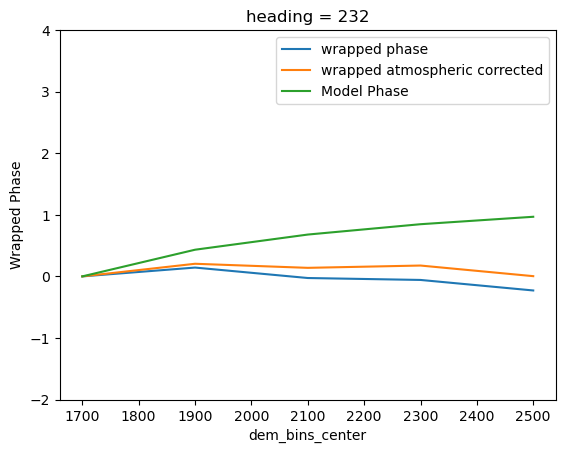

In [42]:
t = 1
fig, ax = plt.subplots()
elev_phase['int_phase'].plot(ax = ax, label = 'wrapped phase')
elev_phase['int_atm'].plot(ax = ax, label = 'wrapped atmospheric corrected')
phase_from_depth(elev_phase['model_d_swe']*997/250, np.deg2rad(40), density = 250).plot(ax = ax, label = 'Model Phase')
ax.set_ylabel('Wrapped Phase')
ax.set_ylim(-2, 4)
ax.legend()